In [1]:
%load_ext autoreload
%autoreload 2

# Overview
## Motivation
Let us consider the following dataset of observations from a set of meteorological stations, which is composed of two files:
- `ts-df.csv`: a CSV file containing the time series of measurements at the stations
- `station-gser.gpkg`: a GeoPackage file containing the stations' locations

In [2]:
import contextily as cx
import geopandas as gpd
import osmnx as ox
import pandas as pd
import seaborn as sns
import tstore
from meteostations_vector_cube import ts_utils

In [3]:
ts_df_filepath = "../data/interim/netatmo-lausanne-aug-21/ts-df.csv"
station_gser_filepath = "../data/interim/netatmo-lausanne-aug-21/station-gser.gpkg"

The time series file contains the following columns:
- `variable`: the variable measured (e.g., temperature, humidity...)
- `id`: the identifier of the station
- `time`: the time of the measurement
- `value`: the value of the measurement

In [4]:
ts_df = pd.read_csv(ts_df_filepath)
ts_df["time"] = pd.to_datetime(ts_df["time"])
ts_df

,variable,id,time,value
0,humidity,70:ee:50:00:10:f0,2021-08-12 13:00:06,50.0
1,humidity,70:ee:50:00:10:f0,2021-08-12 14:00:11,49.0
2,humidity,70:ee:50:00:10:f0,2021-08-12 15:00:16,50.0
3,humidity,70:ee:50:00:10:f0,2021-08-12 16:00:12,49.0
4,humidity,70:ee:50:00:10:f0,2021-08-12 17:00:10,53.0
...,...,...,...,...
381071,wind_strength,70:ee:50:7f:98:de,2021-08-23 22:00:06,2.0
381072,wind_strength,70:ee:50:7f:98:de,2021-08-25 01:00:04,3.0
381073,wind_strength,70:ee:50:7f:98:de,2021-08-25 02:00:05,3.0
381074,wind_strength,70:ee:50:7f:98:de,2021-08-25 03:00:06,2.0


The GeoPackage file is a geo-series with the stations' locations, indexed by their identifier.

In [5]:
station_gser = gpd.read_file(station_gser_filepath).set_index("index")["geometry"]
station_gser

index
70:ee:50:00:10:f0    POINT (6.89271 46.52302)
70:ee:50:00:17:8e    POINT (6.90578 46.52483)
70:ee:50:00:20:88    POINT (6.91779 46.56574)
70:ee:50:00:30:2a    POINT (6.68442 46.50841)
70:ee:50:00:36:d0    POINT (6.92119 46.65298)
                               ...           
70:ee:50:7a:c4:fc    POINT (6.48343 46.51304)
70:ee:50:7a:d2:c2    POINT (6.95003 46.52200)
70:ee:50:7a:dc:ce    POINT (6.77757 46.48391)
70:ee:50:7a:e3:4a    POINT (6.85159 46.58526)
70:ee:50:7f:98:de    POINT (6.49058 46.51635)
Name: geometry, Length: 748, dtype: geometry

The main issue is that geopandas does not currently feature a way of efficiently representing this information in a single geo-data frame.

The memory usage of `ts_df` is inefficient, as it contains many repreated values for the `variable` and `id` columns.

In [6]:
ts_df.memory_usage(deep=True)

Index            132
variable    25264251
id          28199624
time         3048608
value        3048608
dtype: int64

We can save memory by converting the `variable` and `id` columns to categorical types.

In [7]:
for col in ["variable", "id"]:
    ts_df[col] = ts_df[col].astype("category")
ts_df.memory_usage(deep=True)

Index           132
variable     381649
id           834056
time        3048608
value       3048608
dtype: int64

Ideally, we would like to have a multi-level index with "variable" as the outermost level, followed by "id" and finally "time", so that we can select a variable and a station and then apply time series operations. Alternatively, "time" could come before "id" so that we select a time range first and then apply spatial operations.

In [8]:
ts_gdf = gpd.GeoDataFrame(
    ts_df, geometry=ts_df["id"].map(station_gser), crs=station_gser.crs
)
ts_gdf

,variable,id,time,value,geometry
0,humidity,70:ee:50:00:10:f0,2021-08-12 13:00:06,50.0,POINT (6.89271 46.52302)
1,humidity,70:ee:50:00:10:f0,2021-08-12 14:00:11,49.0,POINT (6.89271 46.52302)
2,humidity,70:ee:50:00:10:f0,2021-08-12 15:00:16,50.0,POINT (6.89271 46.52302)
3,humidity,70:ee:50:00:10:f0,2021-08-12 16:00:12,49.0,POINT (6.89271 46.52302)
4,humidity,70:ee:50:00:10:f0,2021-08-12 17:00:10,53.0,POINT (6.89271 46.52302)
...,...,...,...,...,...
381071,wind_strength,70:ee:50:7f:98:de,2021-08-23 22:00:06,2.0,POINT (6.49058 46.51635)
381072,wind_strength,70:ee:50:7f:98:de,2021-08-25 01:00:04,3.0,POINT (6.49058 46.51635)
381073,wind_strength,70:ee:50:7f:98:de,2021-08-25 02:00:05,3.0,POINT (6.49058 46.51635)
381074,wind_strength,70:ee:50:7f:98:de,2021-08-25 03:00:06,2.0,POINT (6.49058 46.51635)


However, note that we are now repeating the geometry information for each row, which is clearly inefficient:

In [9]:
print(
    "Memory usage (MB) of ts_df + station_gser:",
    (ts_df.memory_usage(deep=True).sum() + station_gser.memory_usage(deep=True)) / 1e6,
)
print("Memory usage (MB) of ts_gdf:", ts_gdf.memory_usage(deep=True).sum() / 1e6)

Memory usage (MB) of ts_df + station_gser: 7.390941
Memory usage (MB) of ts_gdf: 10.361661


Additionally, this is also inneficient for spatial operations as single station
geometries that appear multiple times will be considered independently. Therefore, we
need to find a way to represent the stations as a single geometry.

## Enter tstore

Initialize the `TSTransformer` object:

In [10]:
ts_tf = ts_utils.TSTransformer()

### One-variable case

Let us first select a one-variable time series, e.g., temperature:

In [11]:
t_ts_df = (
    ts_df[ts_df["variable"] == "temperature"]
    # .drop("variable", axis=1)
    .set_index("time").copy()
)
t_ts_df

,variable,id,value
time,,,
2021-08-12 13:00:06,temperature,70:ee:50:00:10:f0,28.1
2021-08-12 14:00:11,temperature,70:ee:50:00:10:f0,29.5
2021-08-12 15:00:16,temperature,70:ee:50:00:10:f0,29.4
2021-08-12 16:00:12,temperature,70:ee:50:00:10:f0,29.2
2021-08-12 17:00:10,temperature,70:ee:50:00:10:f0,27.9
...,...,...,...
2021-08-23 22:00:06,temperature,70:ee:50:7f:98:de,19.0
2021-08-25 01:00:04,temperature,70:ee:50:7f:98:de,17.5
2021-08-25 02:00:05,temperature,70:ee:50:7f:98:de,17.2


For each station, we can wrap the time series of measured values as a `TS` object, so that we can then have a geo-data frame of the following form:

In [12]:
# TODO: what do we gain with TSArray?
t_gdf = ts_tf.to_ts_gdf(t_ts_df, station_gser)
t_gdf

,temperature,geometry
70:ee:50:00:10:f0,<tstore.ts.TS object at 0x79cc63e0b8d0>,POINT (6.89271 46.52302)
70:ee:50:00:17:8e,<tstore.ts.TS object at 0x79cc63e12cd0>,POINT (6.90578 46.52483)
70:ee:50:00:20:88,<tstore.ts.TS object at 0x79cc63e13990>,POINT (6.91779 46.56574)
70:ee:50:00:30:2a,<tstore.ts.TS object at 0x79cc63e12bd0>,POINT (6.68442 46.50841)
70:ee:50:00:36:d0,<tstore.ts.TS object at 0x79cc63e08810>,POINT (6.92119 46.65298)
...,...,...
70:ee:50:7a:c4:fc,<tstore.ts.TS object at 0x79cc6382e110>,POINT (6.48343 46.51304)
70:ee:50:7a:d2:c2,<tstore.ts.TS object at 0x79cc6382f790>,POINT (6.95003 46.52200)
70:ee:50:7a:dc:ce,<tstore.ts.TS object at 0x79cc64e3cb10>,POINT (6.77757 46.48391)
70:ee:50:7a:e3:4a,<tstore.ts.TS object at 0x79cc63e30850>,POINT (6.85159 46.58526)


In [13]:
t_gdf.dtypes

temperature    TS[dask.Series]
geometry              geometry
dtype: object

#### Geospatial query

We now have one row per station, and we can therefore efficiently apply geospatial operations over the geo-data frame, e.g.:

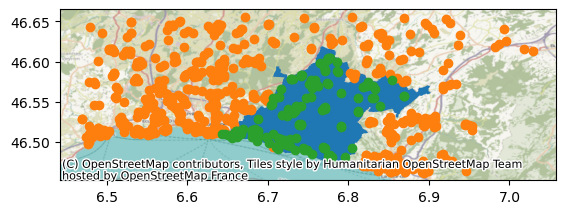

In [14]:
colors = iter(sns.color_palette())
bounds_gdf = ox.geocode_to_gdf("District de Lavaux-Oron, Switzerland").to_crs(t_gdf.crs)
ax = bounds_gdf.plot(color=next(colors))
intersects = t_gdf["geometry"].intersects(bounds_gdf.unary_union)
t_gdf[~intersects].plot(ax=ax, color=next(colors))
t_gdf[intersects].plot(ax=ax, color=next(colors))
cx.add_basemap(ax, crs=t_gdf.crs)

TODO: time filtering

In [15]:
t_gdf["temperature"].iloc[0].data.index > "2021-08-15"

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### Multi-variable case

Let us now consider all variables:

In [16]:
ts_gdf = ts_tf.to_ts_gdf(ts_df, station_gser)
ts_gdf

,humidity,pressure,rain_live,temperature,wind_angle,wind_strength,geometry
70:ee:50:00:10:f0,<tstore.ts.TS object at 0x79cc63735c50>,<tstore.ts.TS object at 0x79cc5960f010>,NaN,<tstore.ts.TS object at 0x79cc5960f150>,NaN,NaN,POINT (6.89271 46.52302)
70:ee:50:00:17:8e,<tstore.ts.TS object at 0x79cc6371a790>,<tstore.ts.TS object at 0x79cc599b7f10>,NaN,<tstore.ts.TS object at 0x79cc593b3610>,NaN,NaN,POINT (6.90578 46.52483)
70:ee:50:00:20:88,<tstore.ts.TS object at 0x79cc637187d0>,<tstore.ts.TS object at 0x79cc637c7b90>,<tstore.ts.TS object at 0x79cc596eec50>,<tstore.ts.TS object at 0x79cc63a9ea50>,NaN,NaN,POINT (6.91779 46.56574)
70:ee:50:00:30:2a,<tstore.ts.TS object at 0x79cc63718250>,<tstore.ts.TS object at 0x79cc6371be90>,NaN,<tstore.ts.TS object at 0x79cc592a2050>,NaN,NaN,POINT (6.68442 46.50841)
70:ee:50:00:36:d0,<tstore.ts.TS object at 0x79cc63719690>,<tstore.ts.TS object at 0x79cc59617c50>,<tstore.ts.TS object at 0x79cc63778d50>,<tstore.ts.TS object at 0x79cc592a11d0>,<tstore.ts.TS object at 0x79cc599c2e50>,<tstore.ts.TS object at 0x79cc58d59590>,POINT (6.92119 46.65298)
...,...,...,...,...,...,...,...
70:ee:50:7a:c4:fc,<tstore.ts.TS object at 0x79cc5960c210>,<tstore.ts.TS object at 0x79cc593a4410>,NaN,<tstore.ts.TS object at 0x79cc58eb3890>,NaN,NaN,POINT (6.48343 46.51304)
70:ee:50:7a:d2:c2,<tstore.ts.TS object at 0x79cc597cfe50>,<tstore.ts.TS object at 0x79cc596fd210>,<tstore.ts.TS object at 0x79cc592a3f90>,<tstore.ts.TS object at 0x79cc58eb2710>,<tstore.ts.TS object at 0x79cc58d47b10>,<tstore.ts.TS object at 0x79cc591b5250>,POINT (6.95003 46.52200)
70:ee:50:7a:dc:ce,<tstore.ts.TS object at 0x79cc597cc5d0>,<tstore.ts.TS object at 0x79cc5958d250>,NaN,<tstore.ts.TS object at 0x79cc58eb24d0>,NaN,NaN,POINT (6.77757 46.48391)
70:ee:50:7a:e3:4a,<tstore.ts.TS object at 0x79cc59744810>,<tstore.ts.TS object at 0x79cc59324d90>,<tstore.ts.TS object at 0x79cc593ec150>,<tstore.ts.TS object at 0x79cc58eb0290>,NaN,NaN,POINT (6.85159 46.58526)


In [ ]:
tstore.TSDF()

## TODO:

- temporal filtering on memory
- multi-variable case
- I/O: temporal and spatial filtering

In [ ]:
gdf

In [ ]:
for station_id, station_df in ts_df.reset_index().groupby("id"):
    print(
        {
            var: var_df.drop("variable", axis=1).set_index("time").squeeze()
            for var, var_df in station_df.drop("id", axis=1).groupby("variable")
        }
    )
    break

In [ ]:
d = {}
for station_id, station_df in ts_df.reset_index().groupby("id"):
    d[station_id] = {
        var: var_df.drop("variable", axis=1).set_index("time").squeeze()
        for var, var_df in station_df.drop("id", axis=1).groupby("variable")
    }
gdf = gpd.GeoDataFrame(pd.Series(d.values(), index=d.keys()), geometry=station_gser)

In [ ]:
gdf.iloc[0]